In [78]:
import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.DEBUG)

2020-01-22T12:26:24.736 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10


In [79]:
# Get stuff in
df_input = pd.read_csv('./CBread0248_Anomaly.csv', index_col=False, parse_dates=['timestamp'])
df_input['entity']=df_input['deviceid']
# and sort it by timestamp
df_input = df_input.sort_values(by='timestamp')
df_input = df_input.set_index(['entity','timestamp']).dropna()

df_input.head(5)




deviceid  floatvalue_kmeansscore  \
entity        timestamp                                                    
CBreadId_0248 2020-01-21 10:30:00  CBreadId_0248                1.141164   
              2020-01-21 10:30:00  CBreadId_0248                2.856042   
              2020-01-21 10:40:00  CBreadId_0248                4.675187   
              2020-01-21 10:40:00  CBreadId_0248                4.675187   
              2020-01-21 10:40:00  CBreadId_0248                5.768771   

                                   floatvalue_FFTScore  \
entity        timestamp                                  
CBreadId_0248 2020-01-21 10:30:00            12.816456   
              2020-01-21 10:30:00            11.678749   
              2020-01-21 10:40:00            12.928282   
              2020-01-21 10:40:00            12.928282   
              2020-01-21 10:40:00            29.916990   

                                   floatvalue_spectralScore  \
entity        timestamp                                       
CBreadId_0248 2020-01-21 10:30:00                 89.566513   
              2020-01-21 10:30:00                 87.250440   
              2020-01-21 10:40:00                 91.848167   
              2020-01-21 10:40:00                 91.848167   
              2020-01-21 10:40:00                 92.049733   

                                   floatvalue_GenScore  floatvalue  
entity        timestamp                                             
CBreadId_0248 2020-01-21 10:30:00            16.012935   25.004330  
              2020-01-21 10:30:00            34.610134   30.008657  
              2020-01-21 10:40:00            10.607640   30.008657  
              2020-01-21 10:40:00            10.607640   30.008657  
              2020-01-21 10:40:00            14.566309   34.995670

In [80]:
sal = SaliencybasedGeneralizedAnomalyScore('floatvalue', 12, 'SaliencyAnomalyScore')
et = sal._build_entity_type(columns = [Column('floatvalue',Float())])
sal._entity_type = et
# sal._entity_type = et2
df_input = sal.execute(df=df_input)
df_input.head(3)

2020-01-22T12:26:26.114 DEBUG mmfunctions.anomaly.__init__ floatvalue
2020-01-22T12:26:26.115 DEBUG mmfunctions.anomaly.__init__ Saliency
2020-01-22T12:26:26.115 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-01-22T12:26:26.116 DEBUG iotfunctions.util.__init__ Starting trace
2020-01-22T12:26:26.116 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_SaliencybasedGeneralizedAnomalyScore_20200122112626
2020-01-22T12:26:26.117 DEBUG iotfunctions.util.__init__ auto_save None
2020-01-22T12:26:26.118 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-01-22T12:26:26.118 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-01-22T12:26:26.119 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-01-22T12:26:26.119 DEBUG iotfunctions.metadata.

deviceid  floatvalue_kmeansscore  \
entity        timestamp                                                    
CBreadId_0248 2020-01-21 10:30:00  CBreadId_0248                1.141164   
              2020-01-21 10:30:00  CBreadId_0248                2.856042   
              2020-01-21 10:40:00  CBreadId_0248                4.675187   

                                   floatvalue_FFTScore  \
entity        timestamp                                  
CBreadId_0248 2020-01-21 10:30:00            12.816456   
              2020-01-21 10:30:00            11.678749   
              2020-01-21 10:40:00            12.928282   

                                   floatvalue_spectralScore  \
entity        timestamp                                       
CBreadId_0248 2020-01-21 10:30:00                 89.566513   
              2020-01-21 10:30:00                 87.250440   
              2020-01-21 10:40:00                 91.848167   

                                   floatvalue_GenScore  floatvalue  \
entity        timestamp                                              
CBreadId_0248 2020-01-21 10:30:00            16.012935   25.004330   
              2020-01-21 10:30:00            34.610134   30.008657   
              2020-01-21 10:40:00            10.607640   30.008657   

                                   SaliencyAnomalyScore  
entity        timestamp                                  
CBreadId_0248 2020-01-21 10:30:00                   1.0  
              2020-01-21 10:30:00                   1.0  
              2020-01-21 10:40:00                   1.0

In [81]:
sps = SpectralAnomalyScore('floatvalue', 12, 'floatValue_spectralScore')
et = sps._build_entity_type(columns = [Column('floatvalue',Float())])
sps._entity_type = et
# sal._entity_type = et2
df_input = sps.execute(df=df_input)
df_input.head(3)

2020-01-22T12:26:27.395 DEBUG mmfunctions.anomaly.__init__ floatvalue
2020-01-22T12:26:27.398 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-01-22T12:26:27.400 DEBUG iotfunctions.util.__init__ Starting trace
2020-01-22T12:26:27.400 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_SpectralAnomalyScore_20200122112627
2020-01-22T12:26:27.401 DEBUG iotfunctions.util.__init__ auto_save None
2020-01-22T12:26:27.401 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-01-22T12:26:27.402 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-01-22T12:26:27.402 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-01-22T12:26:27.402 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:None
Functions:
Granularities:
No 

/home/markus/.local/lib/python3.7/site-packages/sklearn/covariance/robust_covariance.py:646: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


deviceid  floatvalue_kmeansscore  \
entity        timestamp                                                    
CBreadId_0248 2020-01-21 10:30:00  CBreadId_0248                1.141164   
              2020-01-21 10:30:00  CBreadId_0248                2.856042   
              2020-01-21 10:40:00  CBreadId_0248                4.675187   

                                   floatvalue_FFTScore  \
entity        timestamp                                  
CBreadId_0248 2020-01-21 10:30:00            12.816456   
              2020-01-21 10:30:00            11.678749   
              2020-01-21 10:40:00            12.928282   

                                   floatvalue_spectralScore  \
entity        timestamp                                       
CBreadId_0248 2020-01-21 10:30:00                 89.566513   
              2020-01-21 10:30:00                 87.250440   
              2020-01-21 10:40:00                 91.848167   

                                   floatvalue_GenScore  floatvalue  \
entity        timestamp                                              
CBreadId_0248 2020-01-21 10:30:00            16.012935   25.004330   
              2020-01-21 10:30:00            34.610134   30.008657   
              2020-01-21 10:40:00            10.607640   30.008657   

                                   SaliencyAnomalyScore  \
entity        timestamp                                   
CBreadId_0248 2020-01-21 10:30:00                   1.0   
              2020-01-21 10:30:00                   1.0   
              2020-01-21 10:40:00                   1.0   

                                   floatValue_spectralScore  
entity        timestamp                                      
CBreadId_0248 2020-01-21 10:30:00                       0.0  
              2020-01-21 10:30:00                       0.0  
              2020-01-21 10:40:00                       0.0

In [135]:
from scipy.signal import savgol_filter
df = df_input.copy()

#df['floatvalue'] = savgol_filter(df['floatvalue'], 51, 3) # window size 51, polynomial order 3

df['floatvalue'].size

13

In [82]:
EngineLogging.configure_console_logging(logging.INFO)

df_input2 = df_input.loc[['CBreadId_0248']]
df_input2.reset_index(level=[0], inplace=True)

In [95]:
df_input2.iloc[2:3,].index[0]

Timestamp('2020-01-21 10:40:00')

Text(0, 0.5, 'floatvalue')

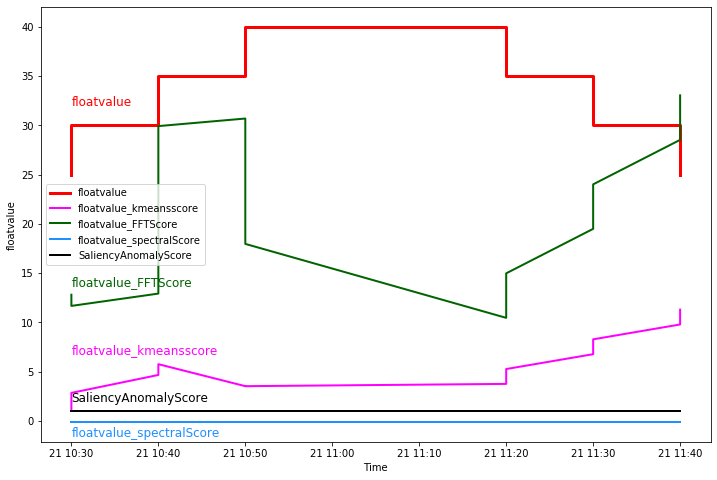

In [143]:
where=df_input2.iloc[1:2,]
Input='floatvalue'
kmeans='floatvalue_kmeansscore'
fft='floatvalue_FFTScore'
spectral='floatvalue_spectralScore'
sal='SaliencyAnomalyScore'
gen='floatvalue_GenScore'

fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(df_input2.index, df_input2[Input],linewidth=3,color='red',label=Input)
ax.plot(df_input2.index, df_input2['floatvalue_kmeansscore'], linewidth=2, 
        color='magenta',label='floatvalue_kmeansscore')
ax.plot(df_input2.index, df_input2['floatvalue_FFTScore'], linewidth=2,
        color='darkgreen',label='floatvalue_FFTScore')
ax.plot(df_input2.index, np.maximum(-df_input2['floatvalue_spectralScore'],-0.1), linewidth=2,
        color='dodgerblue', label='floatvalue_spectralScore')
ax.plot(df_input2.index, df_input2['SaliencyAnomalyScore'], linewidth=2,
        color='black',label='SaliencyAnomalyScore')
#ax.plot(df_input2.index, df_input2['floatvalue_GenScore'], linewidth=2, ls='-.',
#        color='darkviolet', label='floatvalue_GenScore')
ax.text(where.index[0], where[Input][0] + 2, Input, size=12, color='red')
ax.text(where.index[0], where[kmeans][0] + 4, kmeans, size=12, color='magenta')
ax.text(where.index[0], where[fft][0] + 2, fft, size=12, color='darkgreen')
ax.text(where.index[0], np.maximum(-where[spectral][0], -0.1)-1.5, spectral, size=12, color='dodgerblue')
ax.text(where.index[0], where[sal][0] + 1, sal, size=12, color='black')
#ax.text(where.index[0], where[gen][0] - 1, gen, size=12, color='darkviolet', bbox=dict(fc="none"))
ax.legend()
#ax.set_ylim(60, 90)
ax.set_xlabel('Time')
ax.set_ylabel('floatvalue')

#### Next steps

* Get the anomaly generator working
* Generate randomized timeseries data with anomalies
* Slice it and label the slices by anomaly type (None, Near vertical line, flat line, ...)
* Apply spectral residual transformation (aka Saliency) to the slices
* Train a plain CNN to classify anomalies - see also SpectralResidualCNN

In [ ]:
from scipy.signal import savgol_filter